In [ ]:
import os
from pathlib import Path
import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.translate.bleu_score import corpus_bleu

from keras.models import Model
from keras.models import load_model
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


# Load Data from GDrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Read and Prepare Data for Model Input
I read the data from GDrive and add placeholder tokens to denote the start and end of a sequence. These are added to every tweet in the dataset.

The placeholders are required for the RNN.

In [ ]:
data_df = pd.read_csv('/content/drive/My Drive/Capstone/processed_tweets.csv', index_col=0)
# Add placeholder to start and end of tweet
data_df['tweet_text'] = data_df['tweet_text'].apply(lambda x: ' '.join(['startseq', x, 'endseq']))
#update n_tokens
data_df['n_tokens'] = data_df['n_tokens'] + 2
data_df

,tweet_text,emojis,emojis_unq,n_tokens,n_emojis,n_emojis_unq
1,startseq Thanks so much pretty Means a lot 🥺 🥺...,🥺 🥺 💖 💖 😳 💀,💀 💖 😳 🥺,23,6,4
10,startseq love you more 😍 😍 🥵 🥵 🥵 endseq,😍 😍 🥵 🥵 🥵,😍 🥵,10,5,2
14,startseq came home to gifts for no reason 🥺 🥺 ...,🥺 🥺,🥺,13,2,1
20,startseq الحمدللهههه 💛 💛 💛 💛 endseq,💛 💛 💛 💛,💛,7,4,1
25,startseq Especially when you lose in that 8 ba...,😂 😂,😂,13,2,1
...,...,...,...,...,...,...
683342,startseq I thought sac meant bag in French so ...,🤣,🤣,15,1,1
683347,startseq Re tla bona 🤣 🤣 🤣 endseq,🤣 🤣 🤣,🤣,8,3,1
683353,startseq Loveeeee 🥰 endseq,🥰,🥰,4,1,1
683354,startseq Can imagine its Rocking to BLUE MOON ...,😎 🍺 🍹,🍹 🍺 😎,13,3,3


I need to keep track of the maximum number of tokens in a tweet, and the size of the vocabulary, as they dictate the size of vectors used in the model.


In [ ]:
n_max_tokens = data_df['n_tokens'].max()

# Arbitrary choice. 
# TODO: Check word counts and use 95percentile or some other more robust way of choosing this value
n_max_vocab_size = 20000

tokenizer = Tokenizer(num_words=n_max_vocab_size, oov_token='<unk>')
tokenizer.fit_on_texts(data_df['tweet_text'])
# word_index returns the actual vocab size of the corpus
# but uses the max vocab size passed on in num_words
# see: https://stackoverflow.com/questions/46202519/keras-tokenizer-num-words-doesnt-seem-to-work
# add 1 to account for <unk>
actual_vocab_size = len(tokenizer.word_index) + 1

print(f'Maximum number of tokens per tweet: {n_max_tokens}')
print(f'Actual vocabulary size: {actual_vocab_size}')
print(f'Using the top {n_max_vocab_size} most frequent words')


Maximum number of tokens per tweet: 32
Actual vocabulary size: 75454
Using the top 20000 most frequent words


## Load Word2Vec Model
I load the word2vec model that will be used to create the feature vector. Each emoji is converted to a vector using this model. I create a helper function to quickly convert a string of emojis (as it is stored in the dataframe), into the resulting feature vector. The feature vector is the sum of the vector representations of each emoji in the string.


In [ ]:
# w2v_model loaded outside of the function to prevent loading the model on every function call
w2v_model = Word2Vec.load('/content/drive/My Drive/Capstone/w2v_all.model')
def vectorize_emojis(emoji_str):
    emojis = emoji_str.split(' ')
    vec_sum = np.zeros(300)
    for emj in emojis:
        try:
            vec = w2v_model.wv[emj]
            vec_sum += vec
        except KeyError:
            pass
            #print(f'Emoji not in w2v: {emj}')
            #ignoring emojis not in the list
    return vec_sum

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Creating the Input to the Model
The tweet text has to be expanded into partial sequences so that it can be fed into the RNN. The partial sequences are essentially concatenated with the feature vector.

The `create_sequences` function will generate this data. Though it is very memory intensive, and I had to implement a data generator.

In [ ]:
# function taken and adapted from: https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/
def create_sequences(df, n_max_tokens, vocab_size):
  # initiate empty lists
  rnn_seqs, emoji_vecs, y = [], [], []
  #I'm iterating over a df, yuck
  #just cant think of the alternative atm
  for _, row in df.iterrows():
    tweet_text = row['tweet_text']
    emoji_vec = vectorize_emojis(row['emojis'])
    seq = tokenizer.texts_to_sequences([tweet_text])[0]
    for i in range(1, len(seq)):
      # split into input and output pair
      in_seq, out_seq = seq[:i], seq[i]
      # pad input sequence
      in_seq = pad_sequences([in_seq], maxlen=n_max_tokens)[0]
      # encode output sequence
      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
      emoji_vecs.append(emoji_vec)
      rnn_seqs.append(in_seq)
      y.append(out_seq)
  return np.array(emoji_vecs), np.array(rnn_seqs), np.array(y)

In [ ]:
# functions taken and adapted from: https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/
def model_data_generator(df, n_max_tokens, vocab_size):
  while 1:
    for _, row in df.iterrows():
      tweet_text = row['tweet_text']
      emoji_str = row['emojis']
      emoji_vecs, rnn_seqs, y = create_sequences_gen(tweet_text, emoji_str, n_max_tokens, vocab_size)
      yield [[emoji_vecs, rnn_seqs], y]

def create_sequences_gen(tweet_text, emoji_str, n_max_tokens, vocab_size):
  # initiate empty lists
  rnn_seqs, emoji_vecs, y = [], [], []
  emoji_vec = vectorize_emojis(emoji_str)
  seq = tokenizer.texts_to_sequences([tweet_text])[0]
  for i in range(1, len(seq)):
    # split into input and output pair
    in_seq, out_seq = seq[:i], seq[i]
    # pad input sequence
    in_seq = pad_sequences([in_seq], maxlen=n_max_tokens)[0]
    # encode output sequence
    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
    emoji_vecs.append(emoji_vec)
    rnn_seqs.append(in_seq)
    y.append(out_seq)
  return np.array(emoji_vecs), np.array(rnn_seqs), np.array(y)

## Defining the Model


In [ ]:
# function taken and adapted from: https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/
def define_model(n_max_tokens, vocab_size):
  # feature extractor model
  inputs1 = Input(shape=(300,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)
  # sequence model
  inputs2 = Input(shape=(n_max_tokens,))
  se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)
  # decoder model
  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  # summarize model
  print(model.summary())
  return model

In [ ]:
# Save an empty model that I can use to "reset" my weights
model = define_model(n_max_tokens, n_max_vocab_size)
#model.save('/content/drive/My Drive/Capstone/tweetmoji_empty_model.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 256)      5120000     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 300)          0           input_1[0][0]                    
____________________________________________________________________________________________

In [ ]:
os.environ['TZ'] = 'America/Toronto'
date_str = datetime.datetime.now().strftime('%Y%m%d_%H%M')
output_dir = f"/content/drive/My Drive/Capstone/model_output/{date_str}"
print(f'OUTPUT: {output_dir}')
Path(output_dir).mkdir(parents=True, exist_ok=True)
output_filename=os.path.join(output_dir, "tweetmoji-epoch{epoch}.h5")
checkpoint = ModelCheckpoint(output_filename, monitor='loss', period=1)
callbacks_list = [checkpoint]

n_samples = 4000
n_epochs = 10
input_df = data_df[['tweet_text', 'emojis']].head(n_samples)
data_gen = model_data_generator(input_df, n_max_tokens, n_max_vocab_size)
# reset model
model = load_model('/content/drive/My Drive/Capstone/tweetmoji_empty_model.h5')
model_history = model.fit_generator(data_gen, epochs=n_epochs, steps_per_epoch=n_samples, verbose=1, callbacks=callbacks_list)
#model.save('/content/drive/My Drive/Capstone/tweetmoji_ep5_n4000_gen')
model_history_df = pd.DataFrame(model_history.history)
model_history_df.index.name = 'epoch'
model_history_df.to_csv(os.path.join(output_dir, 'history.csv'))

OUTPUT: /content/drive/My Drive/Capstone/model_output/20200625_0254


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
4000/4000 [==============================] - 343s 86ms/step - loss: 6.4869
Epoch 2/10
4000/4000 [==============================] - 347s 87ms/step - loss: 5.4359
Epoch 3/10
4000/4000 [==============================] - 345s 86ms/step - loss: 5.0632
Epoch 4/10
4000/4000 [==============================] - 344s 86ms/step - loss: 4.7362
Epoch 5/10
4000/4000 [==============================] - 342s 85ms/step - loss: 4.4616
Epoch 6/10
4000/4000 [==============================] - 342s 85ms/step - loss: 4.2329
Epoch 7/10
3000/4000 [=====================>........] - ETA: 1:26 - loss: 3.9594

## Generating Tweets

Here I define a function that is used to iteratively query the model to generate tweet. 


In [ ]:
def generate_tweet(tweetmoji_model, tokenizer, n_max_tokens, in_emojis, in_text = 'startseq'):
  emoji_vec = vectorize_emojis(in_emojis)
  seq = tokenizer.texts_to_sequences([in_text])[0]
  endseq = tokenizer.texts_to_sequences(['endseq'])[0]
  for i in range(n_max_tokens):
    seq_pad = pad_sequences([seq],maxlen=n_max_tokens)
    y_pred = np.argmax(tweetmoji_model.predict([[emoji_vec], seq_pad]))
    seq.append(y_pred)
    if y_pred == endseq[0]:
      break
  tweet = tokenizer.sequences_to_texts([seq])[0]
  return tweet

In [ ]:
model_filename = '/content/drive/My Drive/Capstone/model_output/20200621_0239/tweetmoji-epoch06-loss4.5979.h5'
model = load_model(model_filename)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
emoji_inputs = ['💗 🎄 👪', '🎄 👪', '👪', '😍', '🤣', '😡']
generated_tweets = []
for emojis in emoji_inputs:
  gen_tweet = generate_tweet(model, tokenizer, n_max_tokens, emojis)
  
  generated_tweets.append(gen_tweet)
  print (gen_tweet)


ValueError: ignored

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
def evaluate_model(model, df, tokenizer, n_max_tokens):
  actual, predicted = [], []
  bleu_scores = []
  for _, row in df.iterrows():
    # Curently comparing to the only source emoji
    reference_tweets = [row['tweet_text']]
    gen_tweet = generate_tweet(model, tokenizer, n_max_tokens, row['emojis'])
    actual.append(reference_tweets)
    predicted.append(gen_tweet.split())
  # corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
  bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
  bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
  bleu3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
  bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
  return [bleu1, bleu2, bleu3, bleu4]

In [ ]:
model_names = [
'tweetmoji-epoch01-loss6.7349.h5',
'tweetmoji-epoch02-loss5.6913.h5',
'tweetmoji-epoch03-loss5.2914.h5',
'tweetmoji-epoch04-loss5.0304.h5',
'tweetmoji-epoch05-loss4.7909.h5',
'tweetmoji-epoch06-loss4.5979.h5',
'tweetmoji-epoch07-loss4.4017.h5',
'tweetmoji-epoch08-loss4.2939.h5',
'tweetmoji-epoch09-loss4.1471.h5',
'tweetmoji-epoch10-loss4.0349.h5'
]

model_dir = '/content/drive/My Drive/Capstone/model_output/20200621_0239'

n_samples = 1000
input_df = data_df[['tweet_text', 'emojis']].head(n_samples)

bleu_scores = []
for n, model_name in enumerate(model_names):
  epoch = n+1
  model_filename = os.path.join(model_dir, model_name)
  model = load_model(model_filename)
  bleu_scores.append(evaluate_model(model, input_df, tokenizer, n_max_tokens))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
bleu_df = pd.DataFrame(bleu_scores, columns=['bleu-1', 'bleu-2', 'bleu-3', 'bleu-4'])

In [ ]:
bleu_df.to_csv('/content/drive/My Drive/Capstone/bleu_scores_n1000.csv')

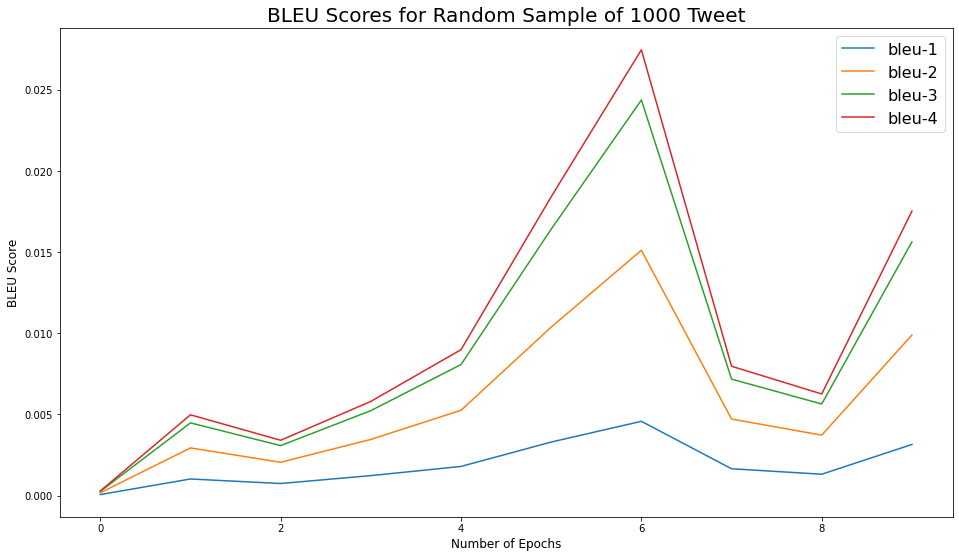

In [ ]:
bleu_df.plot(y=bleu_df.columns, figsize=(16,9))
plt.title('BLEU Scores for Random Sample of 1000 Tweet', fontsize=20)
plt.xlabel('Number of Epochs',fontsize=12)
plt.ylabel('BLEU Score',fontsize=12)
plt.legend(prop={'size': 16})
plt.show()

In [ ]:
model_names = [
'tweetmoji-epoch01-loss6.7349.h5',
'tweetmoji-epoch02-loss5.6913.h5',
'tweetmoji-epoch03-loss5.2914.h5',
'tweetmoji-epoch04-loss5.0304.h5',
'tweetmoji-epoch05-loss4.7909.h5',
'tweetmoji-epoch06-loss4.5979.h5',
'tweetmoji-epoch07-loss4.4017.h5',
'tweetmoji-epoch08-loss4.2939.h5',
'tweetmoji-epoch09-loss4.1471.h5',
'tweetmoji-epoch10-loss4.0349.h5'
]
for epoch, model_name in enumerate(model_names):
  print(epoch)

0
1
2
3
4
5
6
7
8
9
